In [1]:
import xarray as xr
import matplotlib.pyplot as plt

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import xesmf as xe

import os

import sys
sys.path.append('/Users/willatobin/Documents/SIO/ClimateBench2/backend/')
from utils import DataFinder

In [2]:
# monthly
# annual: take annual mean (annual sum for pr)

In [20]:
# setting up constants for each combination

const_dict = {
    'tas': {
        "monthly":{
            'data':{
                'cmap':'viridis',
                'vmin':220,
                'vmax':320,
                'cbar_ticks':[220,245,270,295,320],
                'plot_title': 'Model Data',
            },
            'error':{
                'cmap':'RdBu_r',
                'vmin':-20,
                'vmax':20,
                'cbar_ticks':[-20,-10,0,10,20],
                'plot_title': 'Model Error',
            },
        },
        "annual":{
            'data':{
                'cmap':'viridis',
                'vmin':220,
                'vmax':315,
                'cbar_ticks':[220,245,270,295,320],
                'plot_title': 'Model Data',
            },
            'error':{
                'cmap':'RdBu_r',
                'vmin':-20,
                'vmax':20,
                'cbar_ticks':[-20,-10,0,10,20],
                'plot_title': 'Model Error',
            },
        },
        'obs_path':'/Users/willatobin/Documents/SIO/ClimateBench2/backend/observational_data/tas_HadCRUT5.zarr',
    },
    'pr': {
        "monthly":{
            'data':{
                'cmap':'viridis',
                'vmin':0,
                'vmax':0.0005,
                'cbar_ticks':[0,0.00025,0.0005],
                'plot_title': 'Model Data',
            },
            'error':{
                'cmap':'RdBu',
                'vmin':-0.00025,
                'vmax':0.00025,
                'cbar_ticks':[-0.00025,0,0.00025],
                'plot_title': 'Model Error',
            },
        },
        "annual":{
            'data':{
                'cmap':'viridis',
                'vmin':0,
                'vmax':0.002,
                'cbar_ticks':[0,0.001,0.002],
                'plot_title': 'Model Data',
            },
            'error':{
                'cmap':'RdBu',
                'vmin':-0.001,
                'vmax':0.001,
                'cbar_ticks':[-0.0010,-0.005,0,0.005,0.0010],
                'plot_title': 'Model Error',
            },
        },
        'obs_path':'/Users/willatobin/Documents/SIO/ClimateBench2/backend/observational_data/pr_noaa_gpcp.zarr',
    },
    'clt': {
        "monthly":{
            'data':{
                'cmap':'viridis',
                'vmin':0,
                'vmax':100,
                'cbar_ticks':[0,50,100],
                'plot_title': 'Model Data',
            },
            'error':{
                'cmap':'RdBu_r',
                'vmin':-50,
                'vmax':50,
                'cbar_ticks':[-50,0,50],
                'plot_title': 'Model Error',
            },
        },
        "annual":{
            'data':{
                'cmap':'viridis',
                'vmin':0,
                'vmax':100,
                'cbar_ticks':[0,50,100],
                'plot_title': 'Model Data',
            },
            'error':{
                'cmap':'RdBu_r',
                'vmin':-50,
                'vmax':50,
                'cbar_ticks':[-50,0,50],
                'plot_title': 'Model Error',
            },
        },
        'obs_path':'/Users/willatobin/Documents/SIO/ClimateBench2/backend/observational_data/clt_nasa_modis.zarr',
    },
    'od550aer': {
        "monthly":{
            'data':{
                'cmap':'viridis',
                'vmin':0,
                'vmax':1,
                'cbar_ticks':[0,0.5,1],
                'plot_title': 'Model Data',
            },
            'error':{
                'cmap':'RdBu_r',
                'vmin':-0.5,
                'vmax':0.5,
                'cbar_ticks':[-0.5,0,0.5],
                'plot_title': 'Model Error',
            },
        },
        "annual":{
            'data':{
                'cmap':'viridis',
                'vmin':0,
                'vmax':1,
                'cbar_ticks':[0,0.5,1],
                'plot_title': 'Model Data',
            },
            'error':{
                'cmap':'RdBu_r',
                'vmin':-0.5,
                'vmax':0.5,
                'cbar_ticks':[-0.5,0,0.5],
                'plot_title': 'Model Error',
            },
        },
        'obs_path':'/Users/willatobin/Documents/SIO/ClimateBench2/backend/observational_data/od550aer_nasa_modis.zarr',
    },
}

In [28]:
model = "MPI-ESM1-2-LR" # "CanESM5" #
variable = 'od550aer'
resolution = "monthly"
type = 'error'

In [29]:
data_finder = DataFinder(variable=variable,model=model,start_year=1960,end_year=2024)
model_ds = data_finder.load_model_ds()

obs_ds = xr.open_zarr(const_dict[variable]['obs_path'])

regridder = xe.Regridder(
    obs_ds, model_ds[["lat", "lon"]], "bilinear", periodic=True
)
obs_rg_ds = regridder(obs_ds[variable], keep_attrs=True)

if resolution == 'annual':
    if variable == 'pr':
        plot_ds = model_ds.groupby('time.year').sum()
        obs_annual = obs_rg_ds.groupby('time.year').sum()
    else:
        plot_ds = model_ds.groupby('time.year').mean()
        obs_annual = obs_rg_ds.groupby('time.year').mean()

    if type == "error":
        plot_ds = plot_ds.sel(year=obs_annual.year.values) - obs_annual

    plot_ds = plot_ds.rename({'year':'time'})
    
else:
    if type == "error":
        plot_ds = model_ds.sel(time=obs_rg_ds.time.values) - obs_rg_ds
    else:
        plot_ds = model_ds


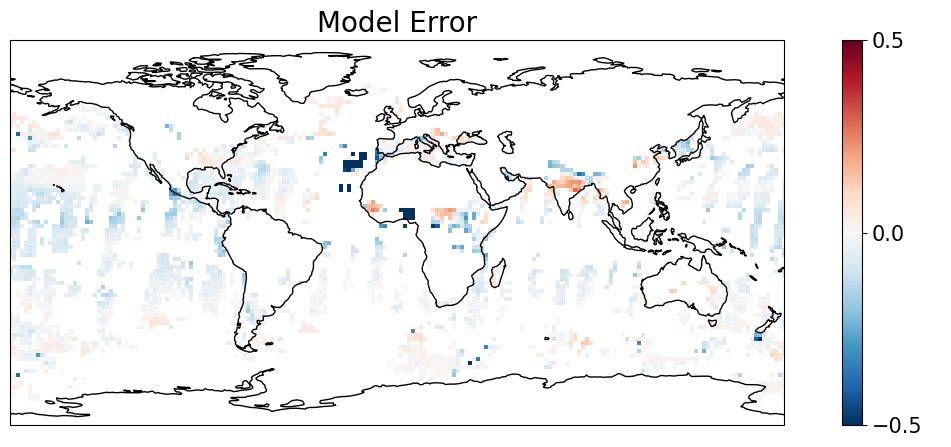

In [30]:
# # plot_ds = (model_ds.sel(time='2000-06-01') - obs_rg_ds.sel(time='2000-06-01'))[variable]
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()},figsize=(15,5))
# Plot the temperature variable
img = plot_ds.isel(time=0)[variable].plot(ax=ax, vmin=const_dict[variable][resolution][type]['vmin'],vmax=const_dict[variable][resolution][type]['vmax'],transform=ccrs.PlateCarree(), add_colorbar=False,cmap=const_dict[variable][resolution][type]['cmap'])
ax.coastlines()
ax.set_title(const_dict[variable][resolution][type]['plot_title'],fontsize=20)

cb = fig.colorbar(img,label=' ',ticks=const_dict[variable][resolution][type]['cbar_ticks']) #
cb.ax.tick_params(labelsize=15)

In [7]:
# for model errors

path = f'/Users/willatobin/Documents/SIO/ClimateBench2/web_static/data/images/{model}/{resolution}/{variable}/{type}/'
os.makedirs(path,exist_ok=True)

for date in plot_ds.time.values:
    
    if resolution == 'annual':
        file = f'{str(date)[:10]}-01-01.png'
    else:
        file = f'{str(date)[:10]}.png'
    file_path = path + file
    # Create a figure and axes with a map projection
    fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()},figsize=(10,5))
    # Plot the temperature variable
    img = plot_ds[variable].sel(time=date).plot(ax=ax, transform=ccrs.PlateCarree(), vmin=const_dict[variable][resolution][type]['vmin'], vmax=const_dict[variable][resolution][type]['vmax'],add_colorbar=False,cmap=const_dict[variable][resolution][type]['cmap'])
    ax.coastlines()
    ax.set_title(const_dict[variable][resolution][type]['plot_title'],fontsize=20)

    cb = fig.colorbar(img,label=' ', ticks=const_dict[variable][resolution][type]['cbar_ticks'])
    cb.ax.tick_params(labelsize=15)


    fig.savefig(file_path,transparent=True,bbox_inches='tight')
    plt.close(fig)

In [ ]:
for model in ["CanESM5", "MPI-ESM1-2-LR"]:
    for variable in ['od550aer']:#['tas','pr','clt']:
        for resolution in ['annual','monthly']:
            for type in ['data','error']:
                print(f"running for combination {model}, {variable}, {resolution}, {type}")
                      
                data_finder = DataFinder(variable=variable,model=model,start_year=1960,end_year=2024)
                model_ds = data_finder.load_model_ds()

                obs_ds = xr.open_zarr(const_dict[variable]['obs_path'])

                regridder = xe.Regridder(
                    obs_ds, model_ds[["lat", "lon"]], "bilinear", periodic=True
                )
                obs_rg_ds = regridder(obs_ds[variable], keep_attrs=True)

                if resolution == 'annual':
                    if variable == 'pr':
                        plot_ds = model_ds.groupby('time.year').sum()
                        obs_annual = obs_rg_ds.groupby('time.year').sum()
                    else:
                        plot_ds = model_ds.groupby('time.year').mean()
                        obs_annual = obs_rg_ds.groupby('time.year').mean()

                    if type == "error":
                        plot_ds = plot_ds.sel(year=obs_annual.year.values) - obs_annual

                    plot_ds = plot_ds.rename({'year':'time'})
                    
                else:
                    if type == "error":
                        plot_ds = model_ds.sel(time=obs_rg_ds.time.values) - obs_rg_ds
                    else:
                        plot_ds = model_ds

                path = f'/Users/willatobin/Documents/SIO/ClimateBench2/web_static/data/images/{model}/{resolution}/{variable}/{type}/'
                os.makedirs(path,exist_ok=True)

                for date in plot_ds.time.values:
                    
                    if resolution == 'annual':
                        file = f'{str(date)[:10]}-01-01.png'
                    else:
                        file = f'{str(date)[:10]}.png'
                    file_path = path + file
                    # Create a figure and axes with a map projection
                    fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()},figsize=(10,5))
                    # Plot the temperature variable
                    img = plot_ds[variable].sel(time=date).plot(ax=ax, transform=ccrs.PlateCarree(), vmin=const_dict[variable][resolution][type]['vmin'], vmax=const_dict[variable][resolution][type]['vmax'],add_colorbar=False,cmap=const_dict[variable][resolution][type]['cmap'])
                    ax.coastlines()
                    ax.set_title(const_dict[variable][resolution][type]['plot_title'],fontsize=20)

                    cb = fig.colorbar(img,label=' ', ticks=const_dict[variable][resolution][type]['cbar_ticks'])
                    cb.ax.tick_params(labelsize=15)


                    fig.savefig(file_path,transparent=True,bbox_inches='tight')
                    plt.close(fig)
